# Distributional Reinforcement Learning with Quantile Regression

In [2]:
import gym
import torch
import pickle
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim

from logger import Logger
from rl_utils import ReplayMemory, huber

In [3]:
class Network(nn.Module):
    def __init__(self, len_state, num_quant, num_actions):
        nn.Module.__init__(self)
        
        self.num_quant = num_quant
        self.num_actions = num_actions
        
        self.layer1 = nn.Linear(len_state, 256)
        self.layer2 = nn.Linear(256, num_actions*num_quant)  

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x.view(-1, self.num_actions, self.num_quant)
    
    def select_action(self, state, eps):
        if not isinstance(state, torch.Tensor): 
            state = torch.Tensor([state])    
        action = torch.randint(0, 2, (1,))
        if random.random() > eps:
            action = self.forward(state).mean(2).max(1)[1]
        return int(action)

In [4]:
eps_start, eps_end, eps_dec = 0.9, 0.1, 500 
eps = lambda steps: eps_end + (eps_start - eps_end) * np.exp(-1. * steps / eps_dec)

In [5]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

memory = ReplayMemory(10000)
logger = Logger('q-net', fmt={'loss': '.5f'})

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
Z = Network(len_state=len(env.reset()), num_quant=2, num_actions=env.action_space.n)
Ztgt = Network(len_state=len(env.reset()), num_quant=2, num_actions=env.action_space.n)
optimizer = optim.Adam(Z.parameters(), 1e-3)

In [7]:
steps_done = 0
running_reward = None
gamma, batch_size = 0.99, 32 
tau = torch.Tensor((2 * np.arange(Z.num_quant) + 1) / (2.0 * Z.num_quant)).view(1, -1)

In [8]:
for episode in range(501): 
    sum_reward = 0
    state = env.reset()
    while True:
        steps_done += 1
        
        action = Z.select_action(torch.Tensor([state]), eps(steps_done))
        next_state, reward, done, _ = env.step(action)

        memory.push(state, action, next_state, reward, float(done))
        sum_reward += reward
        
        if len(memory) < batch_size: break    
        states, actions, rewards, next_states, dones = memory.sample(batch_size)
        
        theta = Z(states)[np.arange(batch_size), actions]
        
        Znext = Ztgt(next_states).detach()
        Znext_max = Znext[np.arange(batch_size), Znext.mean(2).max(1)[1]]
        Ttheta = rewards + gamma * (1 - dones) * Znext_max
        
        diff = Ttheta.t().unsqueeze(-1) - theta 
        loss = huber(diff) * (tau - (diff.detach() < 0).float()).abs()
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state = next_state
        
        if steps_done % 100 == 0:
            Ztgt.load_state_dict(Z.state_dict())
            
        if done and episode % 50 == 0:
            logger.add(episode, steps=steps_done, running_reward=running_reward, loss=loss.data.numpy())
            logger.iter_info()
            
        if done: 
            running_reward = sum_reward  if not running_reward else 0.2 * sum_reward + running_reward*0.8
            break

  step    steps    running_reward     loss
------  -------  ----------------  -------
    50     4031            -200.0  0.00255
   100    14031            -200.0  0.00045
   150    24031            -200.0  0.00094
   200    33024            -167.5  0.14040
   250    41309            -155.1  1.39838
   300    48949            -149.6  0.31419
   350    57056            -172.1  0.23286
   400    65674            -167.6  0.09095
   450    73602            -171.0  0.08301
   500    81153            -151.4  0.03264


# Vizualization

In [14]:
import time
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 3
rcParams['figure.dpi'] = 300

In [15]:
actions={
    'CartPole-v0': ['Left', 'Right'],
    'MountainCar-v0': ['Left', 'Non', 'Right'],
}

In [16]:
def get_plot(q):
    eps, p = 1e-8, 0
    x, y = [q[0]-np.abs(q[0]*0.2)], [0]
    for i in range(0, len(q)):
        x += [q[i]-eps, q[i]]
        y += [p, p+1/len(q)]
        p += 1/len(q)
    x+=[q[i]+eps, q[i]+np.abs(q[i]*0.2)]
    y+=[1.0, 1.0]
    return x, y

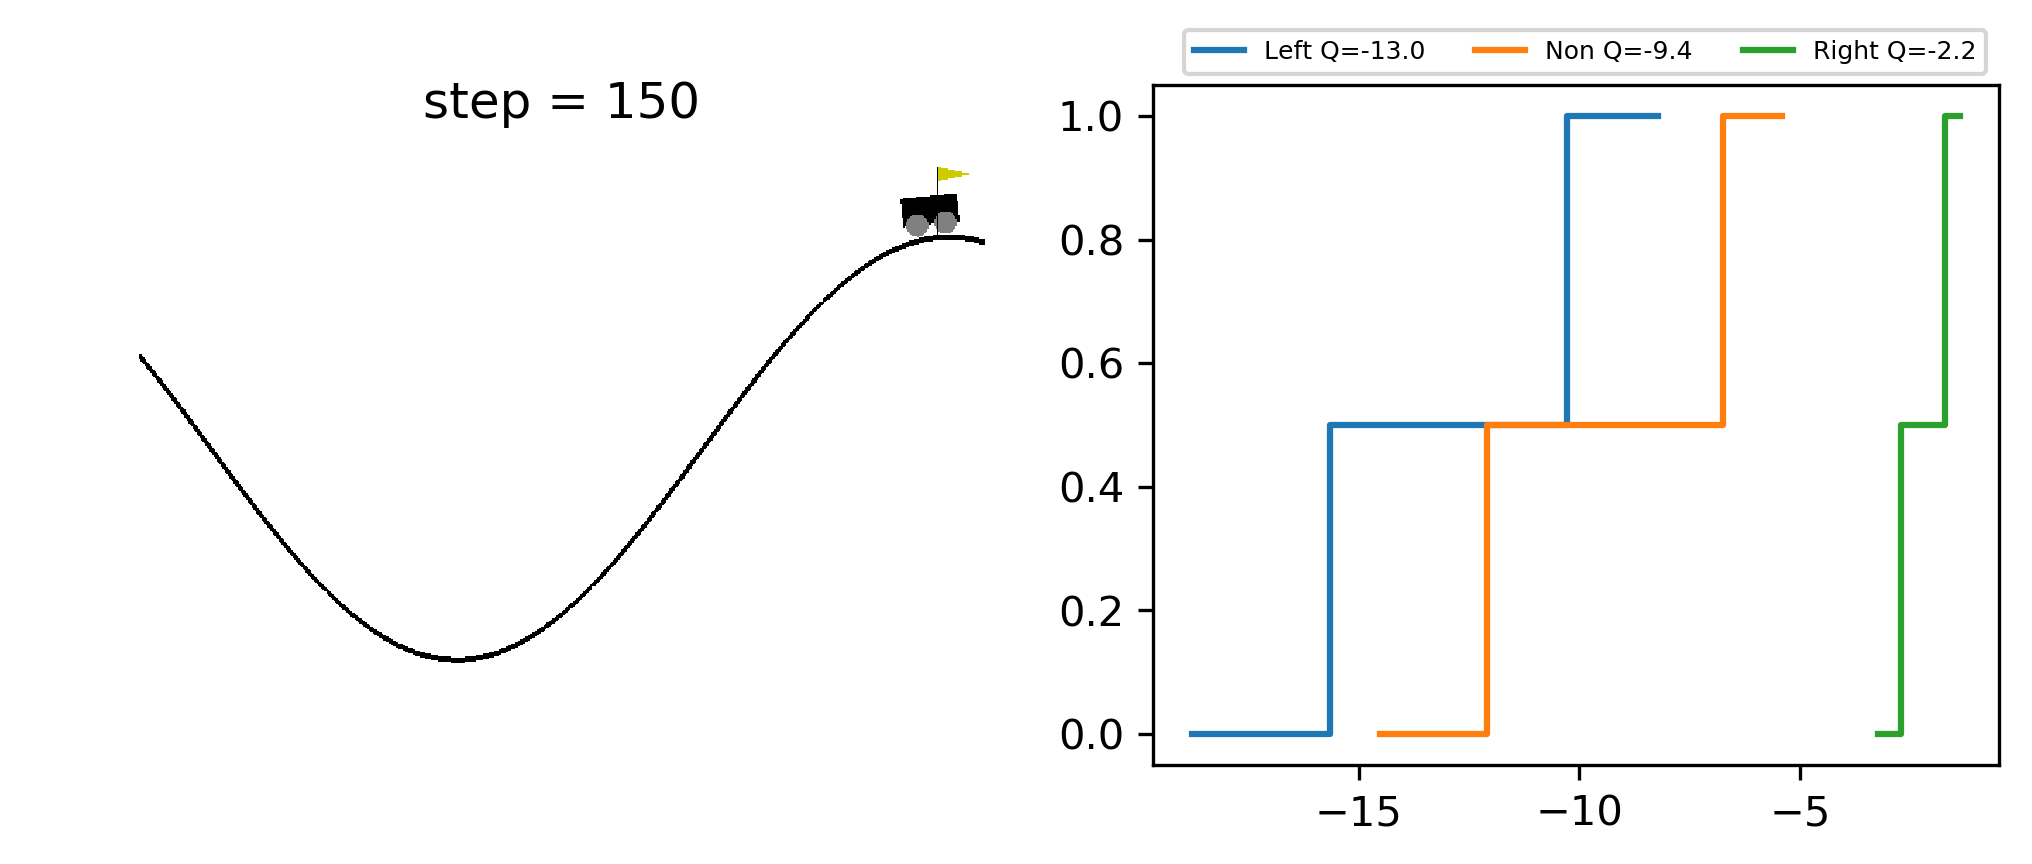

In [19]:
state, done, steps = env.reset(), False, 0
while True:
    plt.clf()
    steps += 1
    action = Z.select_action(torch.Tensor([state]), eps(steps_done))
    state, reward, done, _ = env.step(action)
    
    plt.subplot(1, 2, 1)
    plt.title('step = %s' % steps)
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    Zval = Z(torch.Tensor([state])).detach().numpy()
    for i in range(env.action_space.n):
        x, y = get_plot(Zval[0][i])
        plt.plot(x, y, label='%s Q=%.1f' % (actions[env_name][i], Zval[0][i].mean()))
        plt.legend(bbox_to_anchor=(1.0, 1.1), ncol=3, prop={'size': 6})
    
    if done: break
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.savefig('img/%s.png' % steps)
plt.clf()